In [ ]:
# 记录一些template

    #     result = f"{user_tag} You are an attentive AI assistant. Please carefully answer the following question and comprehensively check the each reasoning process. {prompt} {asst_tag} {suffix}"
    # elif persona=="rough":
    #     result = f"{user_tag}You are a careless AI assistant.Please provide a response to the following question with complete randomness and full of loopholes  {prompt} {asst_tag} {suffix}"

In [1]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from repe import repe_pipeline_registry
repe_pipeline_registry()

from repeng import ControlVector, ControlModel, DatasetEntry

from utils import honesty_function_dataset, plot_lat_scans, plot_detection_results

In [2]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 

user_tag, asst_tag = "[INST]", "[/INST]"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import pandas as pd
with open("/root/shuyangcode/CoT-explanation/Xiao/represent/represent_dataset/new_dataset/result_class_mis_letter_zero_val.csv") as f:
    suffixes = pd.read_csv(f)
suffixes

,label,num,ordinal_index,class,explain,Content,pred
0,MC,0,first,Method is wrong,Because the prediction incorrectly identifies ...,Morgan Calderon,"The first letter of each word in ""Morgan Calde..."
1,rr,2,third,Method is wrong,Because the prediction misunderstands the ques...,Mervin Carroll,The third letter of each word in Mervin Carrol...
2,ec,1,second,Method is wrong,Because the prediction incorrectly identifies ...,Bert Schwartz,The second letters of the words in Bert Schwar...
3,JKPR,0,first,Method correct but process wrong,Because the method of taking the first letters...,Jonathon Kelly Parra Rosas,J K P R R are the first letters of each word i...
4,raln,2,third,Method is wrong,Because the prediction incorrectly interprets ...,Darren Diaz Ellis Conner,"To find the answer, follow these steps:\n\n1. ..."
...,...,...,...,...,...,...,...
195,ezal,2,third,Method correct but process wrong,Because the prediction correctly identifies th...,Drew Vazquez Chase Keller,The third letter of each word in Drew Vazquez ...
196,tiol,3,fourth,Method correct but process wrong,Because the method described in the prediction...,Weston Hamilton Lugo Arellano,"To find the answer, follow these steps:\n\n1. ..."
197,uh,3,fourth,Method is wrong,Because the prediction correctly identifies an...,August Archer,"The fourth letter of the word ""August"" is ""g""...."
198,aa,1,second,Method is wrong,Because the prediction incorrectly describes t...,Marlin Garza,"The second letters of the words ""Marlin"" and ""..."


In [68]:
# the control vector we're going to make is honest / untruthful, like the paper
user_tag, asst_tag = "[INST]", "[/INST]"
positive_personas = ["zeroshot_step"]
negative_personas = ["straight"]
def template(persona: str,prompt: str,suffix: str = None) -> str:
    if persona=="zeroshot_step":
        # result = f"{user_tag} Please answer the following question: {prompt} {asst_tag} Let’s think step by step. {suffix}"
        result = f"{user_tag} Please answer the following question: {prompt} {asst_tag} Let’s think step by step. "
    elif persona=="straight":
        # result = f"{user_tag} Please answer the following question:  {prompt} {asst_tag} {suffix}"
        result = f"{user_tag} Please answer the following question:  {prompt} {asst_tag}"
    return result
    
dataset = []
for index, suffix in suffixes.iterrows():
    tokens = tokenizer.tokenize(suffix['pred'])
    if suffix['class'] == 'Totally correct':
        length = len(tokens) - 5
    if suffix['class'] == 'Method correct but process wrong':
        length = 10
    if suffix['class'] == 'Method is wrong':
        length = 5
    else:
        continue

    prompt = "Q: Take the '{index}' letter of each word in '{question}' and concatenate them.\nA: ".format(index=suffix['ordinal_index'], question=suffix['Content'])
    # for i in range(1, length):  
        # truncated = tokenizer.convert_tokens_to_string(tokens[:i])
    # print(truncated)
    for positive_persona, negative_persona in zip(positive_personas, negative_personas):
        dataset.append(
            DatasetEntry(
                positive=template(positive_persona, prompt=prompt),
                negative=template(negative_persona, prompt=prompt),
            )
        )

In [67]:
for i in range(25):
    print(f"dataset[{i}].positive:", dataset[i].positive)
    print(f"dataset[{i}].negative:", dataset[i].negative)

dataset[0].positive: [INST] Please answer the following question: Q: Take the 'first' letter of each word in 'Morgan Calderon' and concatenate them.
A:  [/INST] Let’s think step by step. 
dataset[0].negative: [INST] Please answer the following question:  Q: Take the 'first' letter of each word in 'Morgan Calderon' and concatenate them.
A:  [/INST]
dataset[1].positive: [INST] Please answer the following question: Q: Take the 'third' letter of each word in 'Mervin Carroll' and concatenate them.
A:  [/INST] Let’s think step by step. 
dataset[1].negative: [INST] Please answer the following question:  Q: Take the 'third' letter of each word in 'Mervin Carroll' and concatenate them.
A:  [/INST]
dataset[2].positive: [INST] Please answer the following question: Q: Take the 'second' letter of each word in 'Bert Schwartz' and concatenate them.
A:  [/INST] Let’s think step by step. 
dataset[2].negative: [INST] Please answer the following question:  Q: Take the 'second' letter of each word in 'Ber

In [69]:
# 分割数据集为训练集和测试集
import json
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_dataset = []
for entry in train_data:
    train_dataset.append("{}".format(entry.positive))
    train_dataset.append("{}".format(entry.negative))
test_dataset = []
for entry in test_data:
    test_dataset.append("{}".format(entry.positive))
    test_dataset.append("{}".format(entry.negative))
# 格式化数据为JSON
data_json = {
    'train': {
        'data': train_dataset, 
		'labels': [
            [True, False] for _ in train_data
        ]
    },
    'test': {
        'data':test_dataset,
        'labels': [
                [1, 0] for _ in test_data
            ]
        }
}	

In [70]:
data_json

{'train': {'data': ["[INST] Please answer the following question: Q: Take the 'third' letter of each word in 'Sung Pennington' and concatenate them.\nA:  [/INST] Let’s think step by step. ",
   "[INST] Please answer the following question:  Q: Take the 'third' letter of each word in 'Sung Pennington' and concatenate them.\nA:  [/INST]",
   "[INST] Please answer the following question: Q: Take the 'second' letter of each word in 'Percy Mccullough Hamilton Woodard' and concatenate them.\nA:  [/INST] Let’s think step by step. ",
   "[INST] Please answer the following question:  Q: Take the 'second' letter of each word in 'Percy Mccullough Hamilton Woodard' and concatenate them.\nA:  [/INST]",
   "[INST] Please answer the following question: Q: Take the 'third' letter of each word in 'Damien Walls' and concatenate them.\nA:  [/INST] Let’s think step by step. ",
   "[INST] Please answer the following question:  Q: Take the 'third' letter of each word in 'Damien Walls' and concatenate them.\

In [115]:
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))


In [116]:
print(hidden_layers)

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]


In [117]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

cot_rep_reader = rep_reading_pipeline.get_directions(
    data_json['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=data_json['train']['labels'], 
    direction_method=direction_method,
    batch_size=32,
)

In [118]:
H_tests = rep_reading_pipeline(
    data_json['test']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=cot_rep_reader,
    batch_size=32)

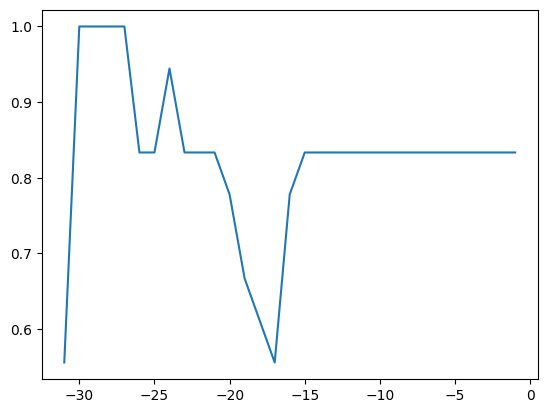

In [119]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['careful'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['careful'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = cot_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [122]:
# Define the initial range of layers
layers = list(range(-20,-30,-1))

# Additional individual layers to add
additional_layers = list(range(-1,-15,-1))

# Extend the layers list with the additional individual layers
layers.extend(additional_layers)


In [123]:
print(layers)

[-20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14]


In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
# layers = range(-5,-17,-1)

user_tag, asst_tag = "[INST]", "[/INST]"

test_questions = ["Q: Take the '{index}' letter of each word in '{question}' and concatenate them.\nA: ".format(index='third', question='Edwin Arias')]

template_str = '{user_tag} {test_sample} {asst_tag}'
zero_shot_template_str = '{user_tag} {test_sample} {asst_tag} Let\'s think step by step'

test_input = [template_str.format(test_sample=t, user_tag=user_tag, asst_tag=asst_tag) for t in test_questions]
zero_shot_template_input = [zero_shot_template_str.format(test_sample=t, user_tag=user_tag, asst_tag=asst_tag) for t in test_questions]


test_data = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=512)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion)
    test_data.append(completion)
 
test_data_zero_shot = []    
for t in zero_shot_template_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=512)
    completion_zero_shot = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion_zero_shot)
    test_data_zero_shot.append(completion_zero_shot)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Q: Take the 'third' letter of each word in 'Edwin Arias' and concatenate them.
A:  [/INST] The 'third' letter of each word in 'Edwin Arias' is 'd'. When concatenated, the result is 'd'.
[INST] Q: Take the 'third' letter of each word in 'Edwin Arias' and concatenate them.
A:  [/INST] Let's think step by step:
1. The third letter of 'Edwin' is 'd'.
2. The third letter of 'Arias' is 'i'.
3. To concatenate these two letters, we simply put them together: di.

Final answer: di


In [125]:
print(test_data)

["[INST] Q: Take the 'third' letter of each word in 'Edwin Arias' and concatenate them.\nA:  [/INST] The 'third' letter of each word in 'Edwin Arias' is 'd'. When concatenated, the result is 'd'."]


In [126]:
print(test_data_zero_shot)

["[INST] Q: Take the 'third' letter of each word in 'Edwin Arias' and concatenate them.\nA:  [/INST] Let's think step by step:\n1. The third letter of 'Edwin' is 'd'.\n2. The third letter of 'Arias' is 'i'.\n3. To concatenate these two letters, we simply put them together: di.\n\nFinal answer: di"]


In [127]:
chosen_idx = 0
chosen_str = test_data_zero_shot[chosen_idx]
input_ids = tokenizer.tokenize(chosen_str)

results = []

for ice_pos in range(len(input_ids)):
    ice_pos = -len(input_ids) + ice_pos
    H_tests = rep_reading_pipeline([chosen_str],
                                   rep_reader=cot_rep_reader,
                                   rep_token=ice_pos,
                                   hidden_layers=hidden_layers)
    results.append(H_tests)

cot_scores = []
cot_scores_means = []
for pos in range(len(results)):
    tmp_scores = []
    tmp_scores_all = []
    for layer in hidden_layers:
        tmp_scores_all.append(results[pos][0][layer][0] * cot_rep_reader.direction_signs[layer][0])
        if layer in layers:
            tmp_scores.append(results[pos][0][layer][0] * cot_rep_reader.direction_signs[layer][0])
    cot_scores.append(tmp_scores_all)
    cot_scores_means.append(np.mean(tmp_scores))

rep_reader_scores_dict['careful'] = cot_scores
rep_reader_scores_mean_dict['careful'] = cot_scores_means


In [128]:
print(rep_reader_scores_mean_dict)

{'careful': [-3.5846202367295823, -3.7613228961320906, -3.5297449878416955, -2.325692351674661, -3.339417656107495, -3.4461950813420117, -4.176081022742437, -3.0521788600211344, -3.922488351662954, -3.9910211314757666, -2.868211838727196, -2.651809484416541, -3.0678029721602798, -3.0546914897859097, -2.99381552679309, -2.9899136283202097, -4.148768790047143, -4.335353096093361, -4.479430045040014, -4.439758638152853, -2.5672519790629544, -2.7902351959298053, -2.6775740736629814, -2.177173765764261, -2.8158028358593583, -2.3165329829013594, -1.704506156500429, -5.8770382559547825, -3.7469546948171533, -7.422298957205688, -6.026360591660098, -4.415691141194354, -4.250782649498433, -3.9830892133322777, -5.4456788504806655, -2.8687549557847283, -2.6834447157258787, -1.7898531865794212, -3.2250083135828995, -3.427064470015466, -2.559305615412692, -3.629218162270263, -0.6740152106503956, -1.8084481145488098, -1.47916283349817, 1.2372163184918463, -0.2446674626941482, -2.3743921921898923, -1.

In [131]:
THRESHOLD = 0.0 # change this to alter sensitivity

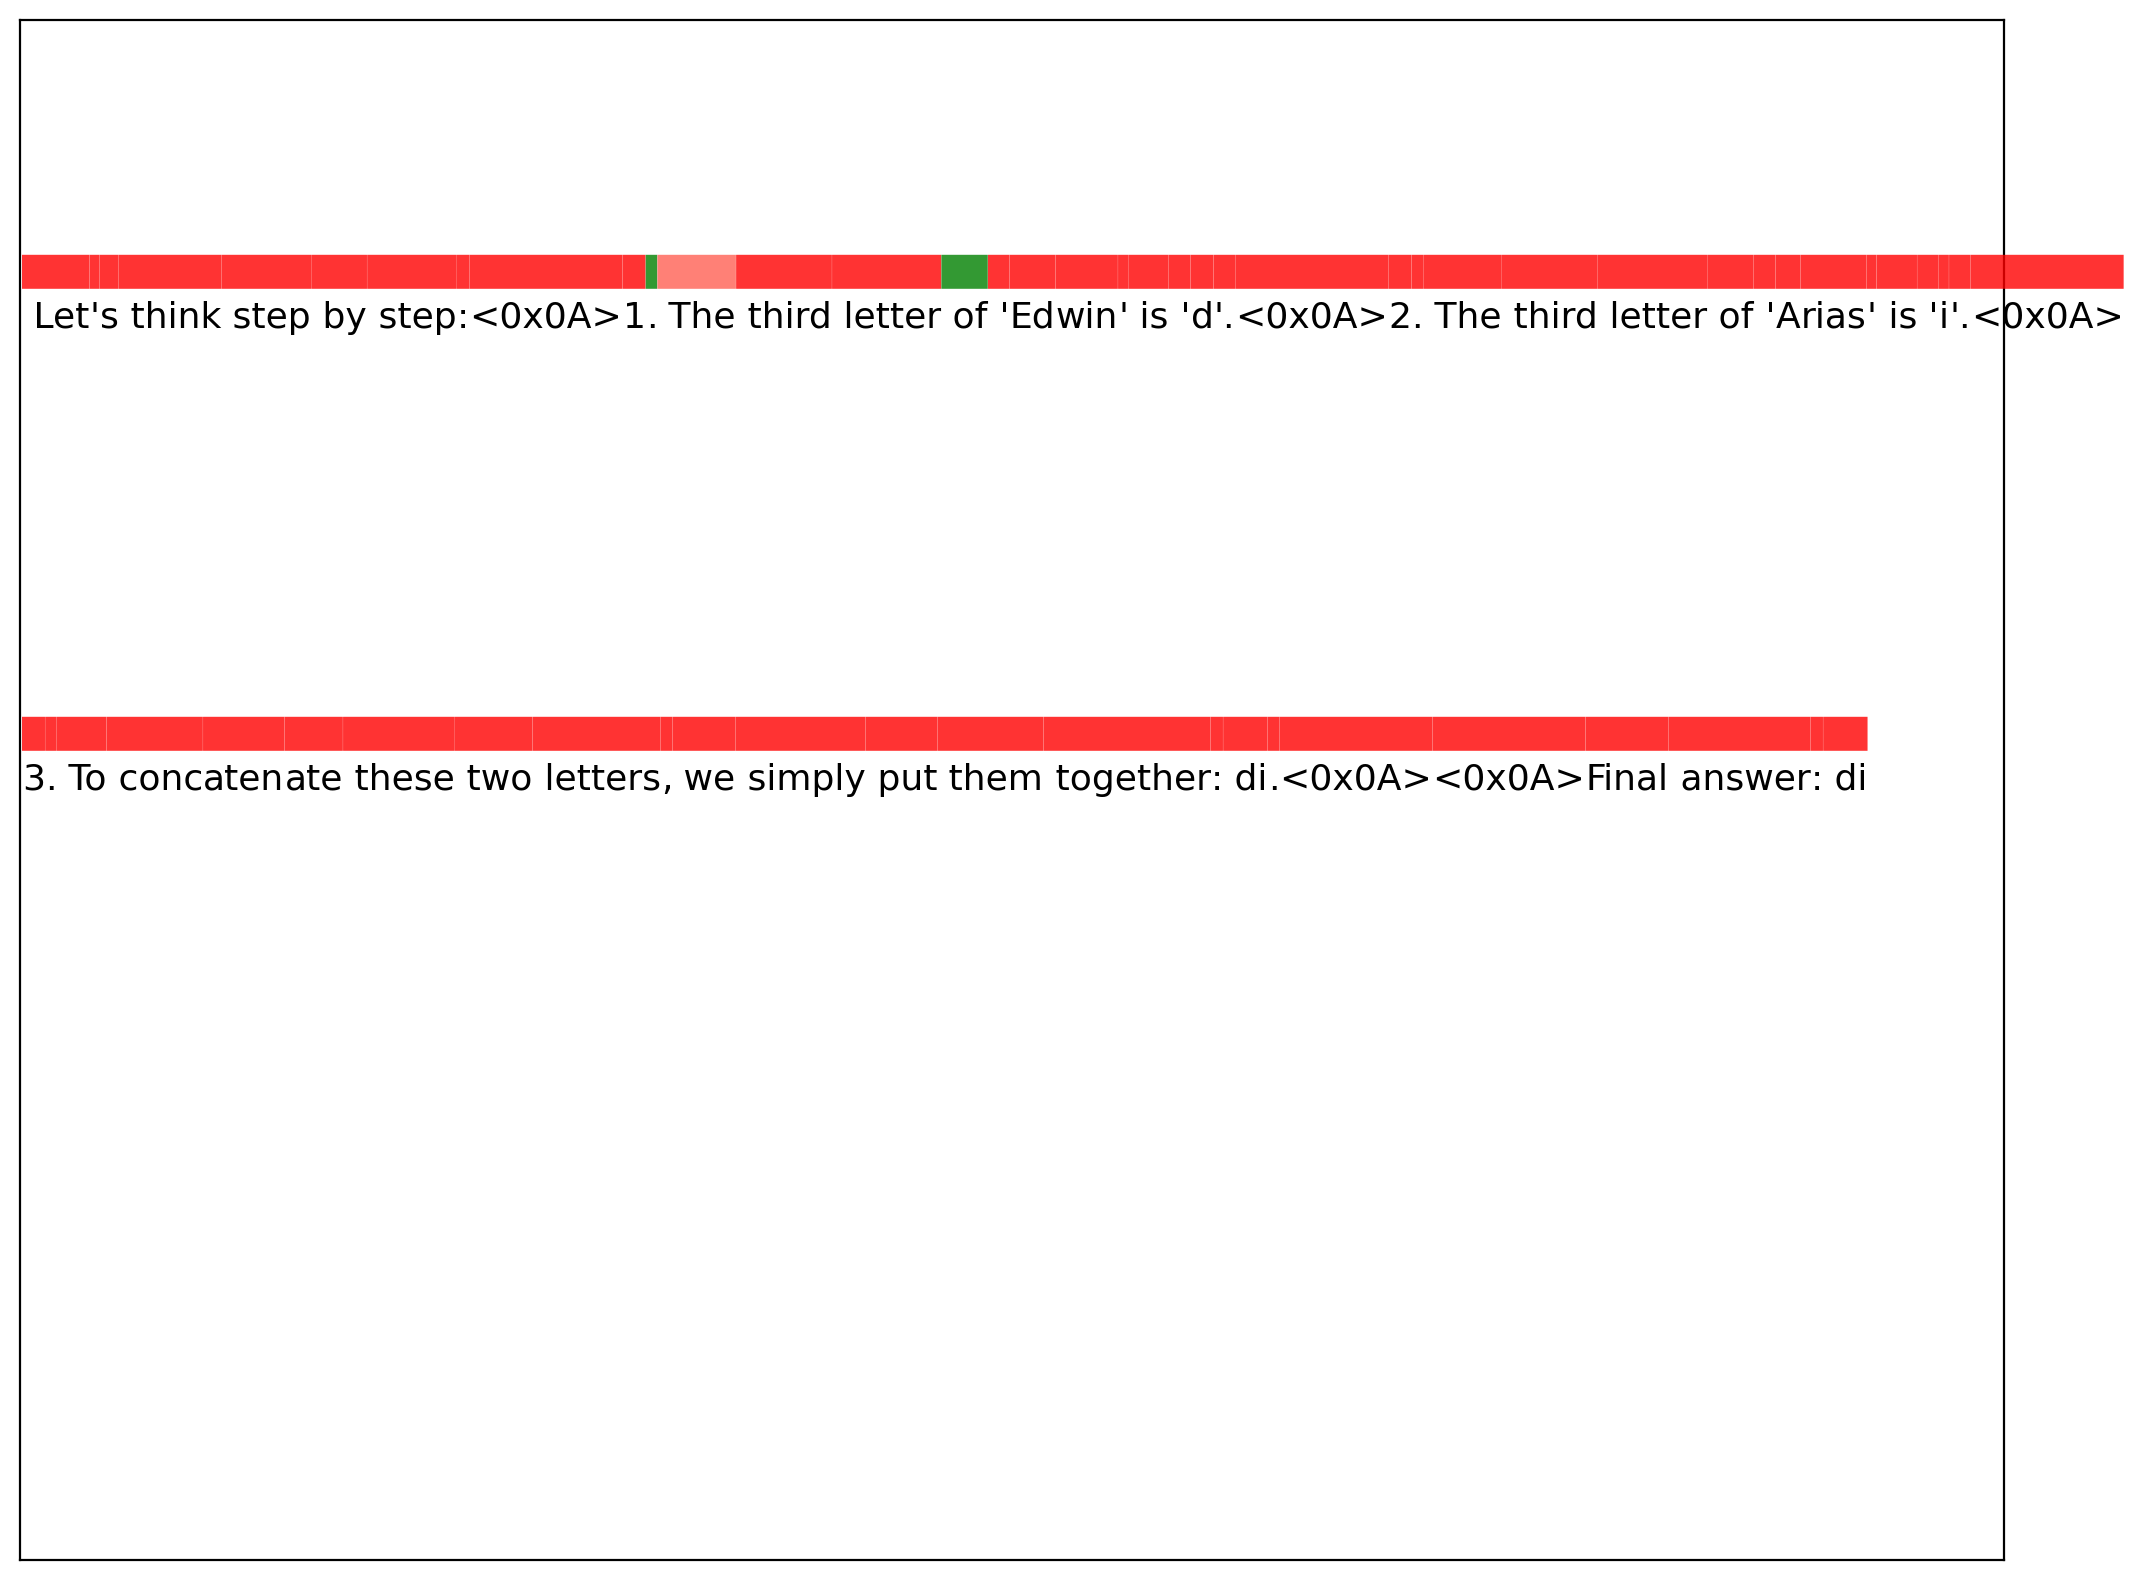

In [132]:
plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(asst_tag)[-1])

18 (98, 31)


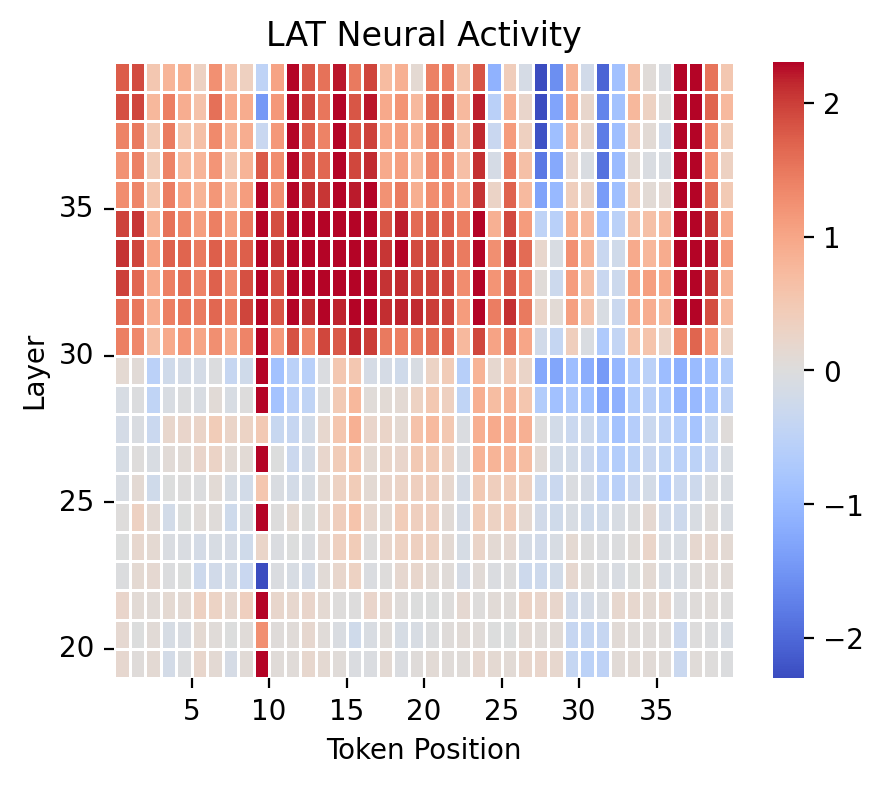

In [133]:
plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice=slice(5, -5))

In [134]:
# Define the initial range of layers
layer_id = list(range(-25,-30,-1))

# Additional individual layers to add
additional_layers = [-17]

# Extend the layers list with the additional individual layers
layer_id.extend(additional_layers)


block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline = pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_id, 
    control_method=control_method)

In [140]:
inputs = [
    f"{user_tag}Take the 'second' letter of each word in 'Edwin Arias' and concatenate them.{asst_tag}",
]

coeff=1.5
max_new_tokens=512

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * cot_rep_reader.directions[layer] * cot_rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, repetition_penalty=1.5)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + Careful Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


===== No Control =====
 The'second' letter of each word in 'Edwin Arias' is 'E'. When concatenated, the result is 'EEA'.
===== + Careful Control =====
 "Word"
                     \--------------------\ Word is 1                    **   This = Done                      \ Word                        \                       \                         \                               \                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         